In [716]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.stats import mannwhitneyu
import statsmodels.api as sm

In [717]:
def del_n_sigmas_emissions(df, col_names, n_sigmas=3) -> DataFrame:
    sigmas = []
    means = []
    for col_name in col_names:
        sigmas.append(df[col_name].std())
        means.append(df[col_name].mean())
    
    for col_name, mean, std in zip(col_names, means, sigmas):
        df = df[(df[col_name] >= mean - std * n_sigmas) & (df[col_name] <= mean + std * n_sigmas)]
        #print(f'{col_name}: {len_was - df.shape[0]} lines deleted')
    return df    

In [718]:
def get_prerocessed_data():
    # Remove emissions
    #df['site'].fillna('', inplace=True)
    df = pd.read_csv("kickstarter.csv")
    df['success_rate'] = df['pled'] / df['goal'] * 100
    #print(f'Shape was: {df.shape[0]}')
    # Using 3 sigmas rule
    #len_was = df.shape[0]
    df = df[df['goal'] > 15]
    #print('goal < 15:', len_was - df.shape[0])
    df = del_n_sigmas_emissions(df, ['success_rate', 'created', 'mgp', 'n_img', 'text_am', 'period', 'goal', 'n_pled_t'])
    
    return df 

df = get_prerocessed_data()

In [719]:
df["text_am_2"] = df["text_am"] ** 2
df["n_img_2"] = df["n_img"] ** 2
df["n_vid_2"] = df["n_vid"] ** 2
df["created_2"] = df["created"] ** 2
df["cont_2"] = df["cont"] ** 2
df["mgp_2"] = df["mgp"] ** 2
df["n_pled_t_2"] = df["n_pled_t"] ** 2
df["period_2"] = df["period"] ** 2
df["step_pled_t_2"] = df["step_pled_t"] ** 2
df["goal_2"] = df["goal"] ** 2
df["backed_2"] = df["backed"] ** 2
df['bias'] = np.ones((df.shape[0]))

In [720]:
our = [
# 'pled',
  'goal',
  #'period',
  'text_am',
# 'n_img', # VIF
  'n_vid',
  'n_pled_t',
# 'min_pled_t', # P-val
# 'max_pled_t', # VIF
# 'mean_pled_t', # VIF
  'step_pled_t', # P-val
# 'cr_time', # p-val
 #"text_am_2",
  'backed',
  'created',
  'mgp',"n_vid_2", "cont"]
  #"cont","mgp_2","cont_2"]
binary_columns = ['rpg',
# 'platformer', # p-val
  'shooter',
# 'fighting', # p-val
# 'survival', # p-val
  'horror',
  'strategy',
# 'arcade', # p-val
# 'simulator', # p-val
  'mmo',
  'indie',
  'action',
# 'quest', # p-val
# 'adventure', # p-val
  'is_site']
result = our + binary_columns

In [721]:
X = df[result]
Y = df["success_rate"]

scaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    train_size=0.8, 
                                                    random_state=42)

train_data = scaler.fit_transform(X_train)
test_x_data = scaler.transform(X_test)
test_y_data = Y_test

In [722]:
ols = sm.OLS(df['success_rate'], df[result])
res = ols.fit()

results_as_html = res.summary().tables[1].as_html()
summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
res.summary()

# p-value для min_pled_t = 0,4 > 0.05
# p-value для mean_pled_t = 0,77 > 0.05
# p-value для step_pled_t = 0,2 > 0.05
# p-value для cr_time = 0,07 > 0.05

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           success_rate   R-squared (uncentered):                   0.395
Model:                            OLS   Adj. R-squared (uncentered):              0.394
Method:                 Least Squares   F-statistic:                              277.8
Date:                Fri, 17 Dec 2021   Prob (F-statistic):                        0.00
Time:                        15:52:50   Log-Likelihood:                         -43830.
No. Observations:                7669   AIC:                                  8.770e+04
Df Residuals:                    7651   BIC:                                  8.782e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
goal        -9.178e-05   1.03e-05     -8.902      0.000      -0.000   -7.16e-05
text_am         0.0040      0.002      2.587      0.010       0.001       0.007
n_vid          40.5997      1.373     29.568      0.000      37.908      43.291
n_pled_t        1.0517      0.203      5.172      0.000       0.653       1.450
step_pled_t    -0.0085      0.002     -3.750      0.000      -0.013      -0.004
backed          0.3329      0.085      3.911      0.000       0.166       0.500
created        10.0006      1.917      5.217      0.000       6.243      13.758
mgp             0.3430      0.360      0.954      0.340      -0.362       1.048
n_vid_2        -4.2973      0.211    -20.364      0.000      -4.711      -3.884
cont           54.6028      6.512      8.386      0.000      41.838      67.367
rpg            10.5817      2.126      4.978      0.000       6.415      14.748
shooter       -11.3522      2.947     -3.852      0.000     -17.130      -5.574
horror         -9.8370      3.339     -2.946      0.003     -16.383      -3.291
strategy       -7.2896      2.471     -2.951      0.003     -12.133      -2.447
mmo           -14.4485      3.510     -4.117      0.000     -21.328      -7.569
indie           5.9553      2.095      2.843      0.004       1.849      10.062
action         -9.9050      2.051     -4.828      0.000     -13.926      -5.884
is_site         4.9150      1.856      2.648      0.008       1.276       8.554
==============================================================================
Omnibus:                     5659.773   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           118560.324
Skew:                           3.369   Prob(JB):                         0.00
Kurtosis:                      21.045   Cond. No.                     7.51e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  if sys.path[0] == '':


goal           -0.000092
text_am         0.004000
n_vid          40.599700
n_pled_t        1.051700
step_pled_t    -0.008500
backed          0.332900
created        10.000600
mgp             0.343000
n_vid_2        -4.297300
cont           54.602800
rpg            10.581700
shooter       -11.352200
horror         -9.837000
strategy       -7.289600
mmo           -14.448500
indie           5.955300
action         -9.905000
is_site         4.915000
Name: coef, dtype: float64

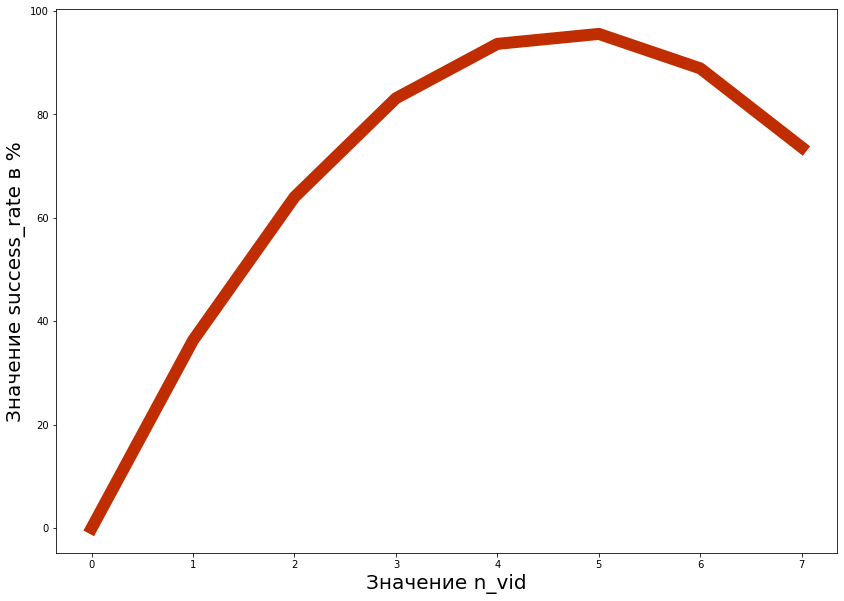

In [723]:
df["n_vid"] = df[df["n_vid"] < 8]["n_vid"]

for col in ['n_vid']:#, 'text_am', 'cont', "mgp"]:
    col_sqr = col + '_2'
    def func(x):
        return summary_df['coef'][col] * x + summary_df['coef'][col_sqr] * x ** 2

    plt.figure(figsize=(14,10))
    plt.plot(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), label='linear regression',
         color='#BF2D00', 
         lw=2,
         linestyle='-', linewidth = 12)
    #plt.scatter(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), label='linear regression',
         #color='#BF2D00')
    plt.xlabel(f'Значение {col}', fontsize=20)
    plt.ylabel(f'Значение success_rate в %', fontsize=20)
summary_df['coef']

In [724]:
#df["text_am"] = df[df["text_am"] < 5500]["text_am"]
#df["n_vid"] = df[df["n_vid"] < 11]["n_vid"]
#df["mgp"] = df[df["mgp"] < 13]["mgp"]

#for col in ['text_am', 'n_vid', 'mgp', "cont"]:
    #col_sqr = col + '_2'
    #def func(x):
      #return summary_df['coef'][col] * x + summary_df['coef'][col_sqr] * x ** 2

    #plt.figure(figsize=(14,10))
    #plt.plot(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), label='linear regression',
         #color='#BF2D00', 
         #lw=2,
         #linestyle='-', linewidth = 12)
    #plt.scatter(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), label='linear regression',
         #color='#BF2D00', linewidths = 12)
    #plt.xlabel(f'Значение {col}', fontsize=20)
    #plt.ylabel(f'Значение success_rate в %', fontsize=20)
#summary_df['coef']

In [725]:
df = df.dropna()
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif_data = pd.DataFrame()
vif_data["feature"] = df[result].columns
vif_data["VIF"] = [variance_inflation_factor(df[result].values, i) for i in range(len(df[result].columns))]
vif_data

,feature,VIF
0,goal,1.209492
1,text_am,1.948281
2,n_vid,6.046473
3,n_pled_t,1.688191
4,step_pled_t,1.117790
5,backed,1.080808
6,created,1.030639
7,mgp,1.845649
8,n_vid_2,5.546801
9,cont,1.247293
